<a href="https://colab.research.google.com/github/emanuel379/Series-Temporais-e-Aprendizado-Dinamico/blob/main/M%C3%B3dulo_5_Data_Analysis_Estat%C3%ADstica_Bayesiana_An%C3%A1lise_de_s%C3%A9ries_temporais_University_of_California%2C_Santa_Cruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages("gtrendsR")
install.packages("dlm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘anytime’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Neste projeto, o senhor fará o download de um conjunto de dados do Google trends. Para fazer isso, o senhor pode digitar um termo ou termos de interesse no Google trends, assim como fizemos com o exemplo com o termo "time series" analisado no curso. O senhor pode usar qualquer termo, como "gripe", "cranberry" ou qualquer outro termo. Aqui está um tutorial sobre como fazer download de dados do Google trends:

Antes de decidir se o conjunto de dados do Google Trends que o senhor obtém para um determinado termo/termos é apropriado para este projeto, ou se precisa usar dados para outro termo/termos, pense cuidadosamente se ele pode ser modelado adequadamente usando um NDLM. Por exemplo, os dados têm um comportamento sazonal? Eles apresentam uma tendência linear de crescimento? Nesse caso, o senhor poderia usar um NDLM com um componente sazonal mais um componente de tendência polinomial. O senhor terá de justificar suas escolhas de modelagem no relatório final. O senhor precisa comunicar claramente suas descobertas em um breve relatório (máximo de 6 páginas).

O objetivo deste projeto de análise de dados é ajudá-lo a:

Tornar-se hábil em todas as etapas do processo de modelagem,

Sintetizar os conceitos ensinados neste curso,

Praticar as técnicas ensinadas no curso e

Comunicar os resultados de forma eficaz.

O senhor precisará: (1) explicar brevemente o conjunto de dados, ou seja, qual(is) termo(s) o senhor pesquisou no Google trends, a taxa de amostragem (semanal, mensal, anual?) e o local dos dados (por exemplo, mundo vs. EUA) e as características gerais dos dados (por exemplo, sazonais (periódicos), quase periódicos, tendência ou outros componentes) (2) justificar sua escolha de modelagem e realizar sua análise.

Para (2), o senhor precisará: Explicar e justificar os componentes que tem no modelo NDLM, ou seja, se incluir tendências polinomiais (qual ordem?), componentes sazonais (qual é o período fundamental e quantas frequências adicionais está incluindo?) ou componentes autorregressivos (qual ordem?), deverá fornecer uma justificativa que explique por que incluiu esses componentes. Em seguida, o senhor realizará uma análise bayesiana e fornecerá resumos de suas distribuições de filtragem, suavização e previsão.  Por fim, será solicitado que o senhor faça um resumo de suas descobertas e espera-se que discuta os resultados de forma eficaz.

[1] "interest_over_time"  "interest_by_country" "interest_by_region" 
[4] "interest_by_dma"     "interest_by_city"    "related_topics"     
[7] "related_queries"

Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward filtering is completed!
Forward 

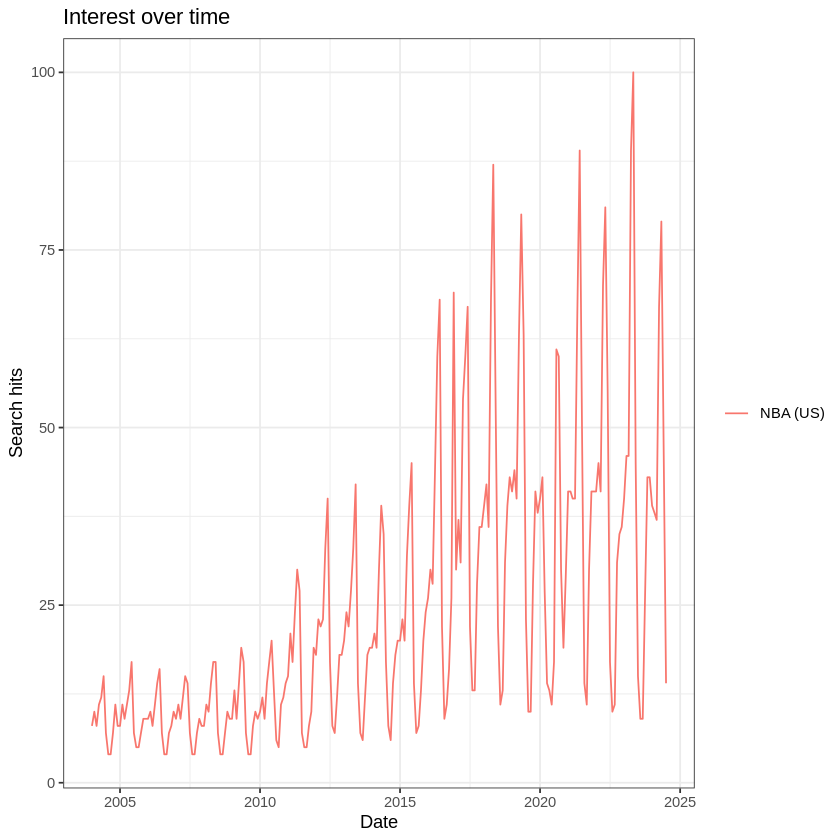

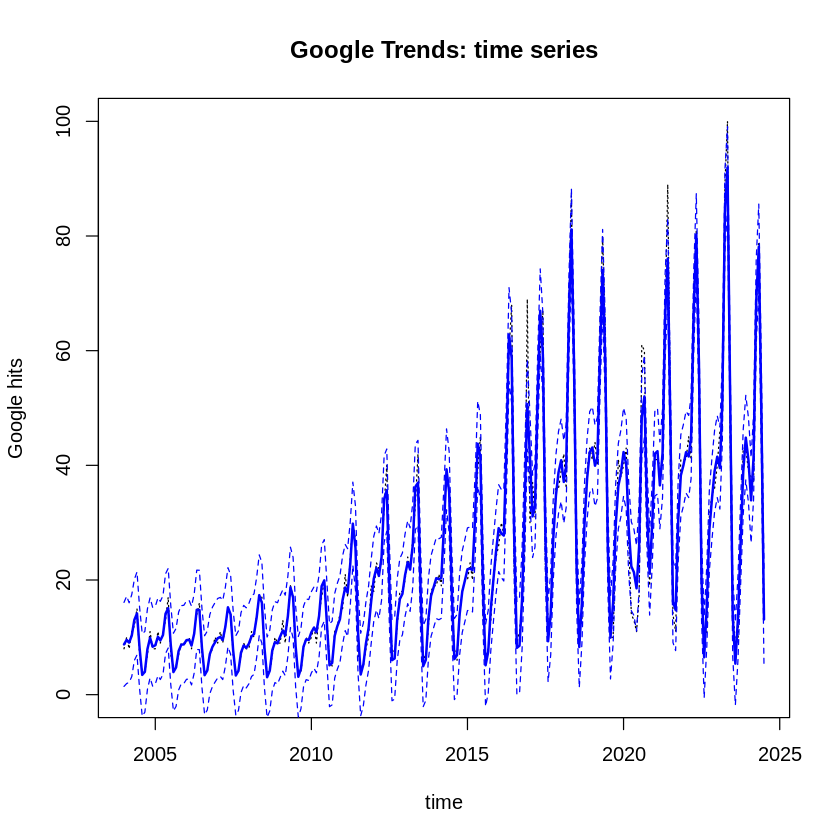

[1] 23.41641

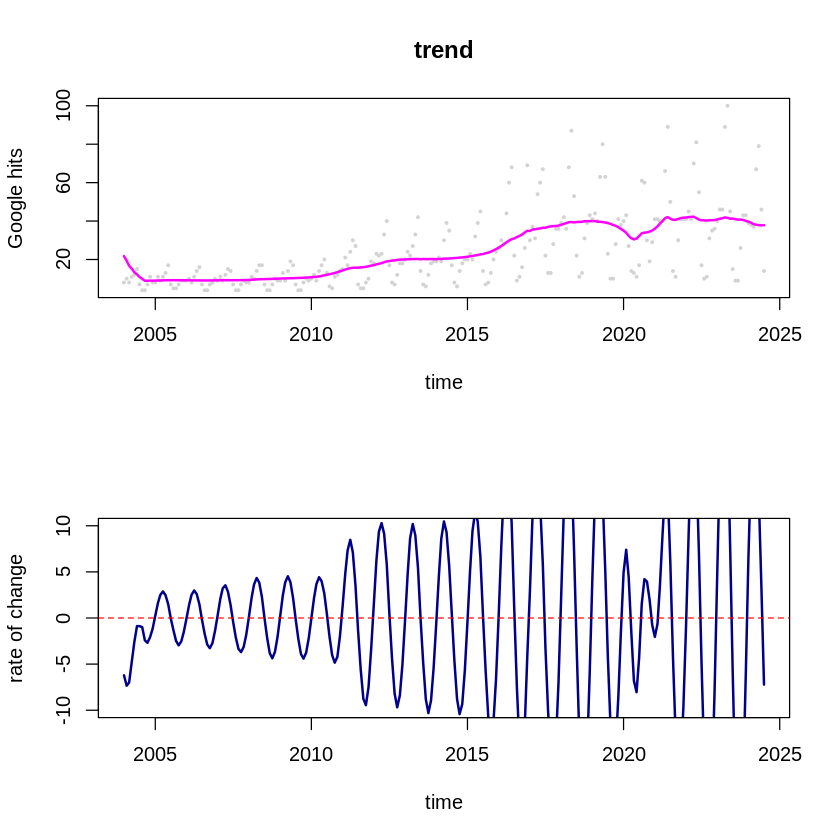

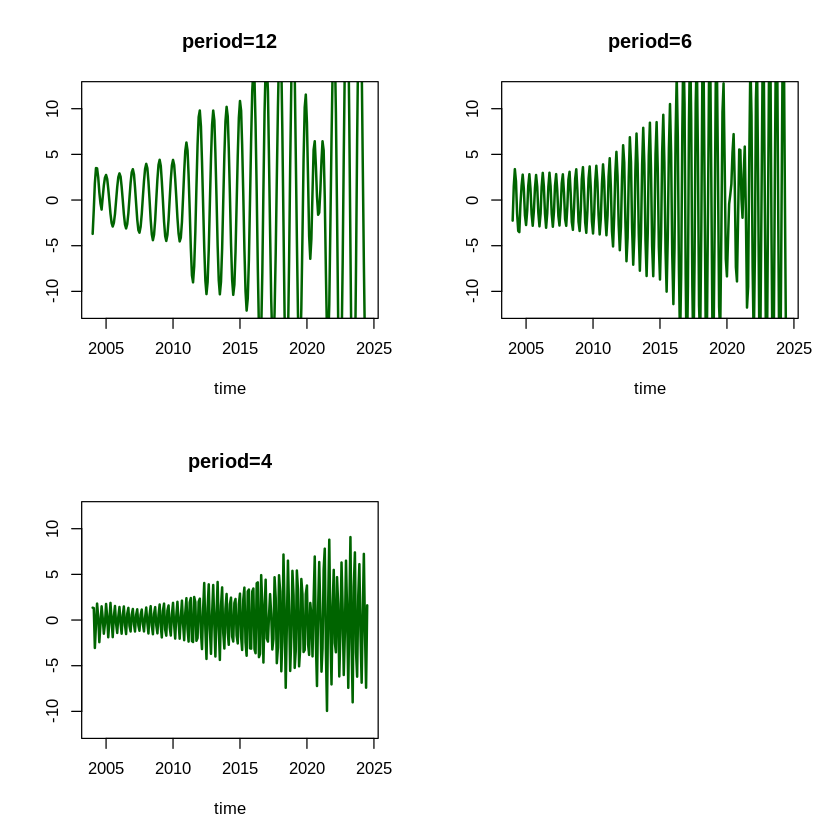

In [63]:
# download data
library(gtrendsR)
timeseries_data<-gtrends("NBA", geo = c ("US"), time="all")
plot(timeseries_data)
names(timeseries_data)

timeseries_data=timeseries_data$interest_over_time
data=list(yt=timeseries_data$hits)

library(dlm)
model_seasonal=dlmModTrig(s=12,q=3,dV=0,dW=1)
model_trend=dlmModPoly(order=1,dV=10,dW=rep(1,1),
m0=c(40))
model=model_trend+model_seasonal
model$C0=10*diag(7)
n0=1
S0=10
k=length(model$m0)
T=length(data$yt)

Ft=array(0,c(1,k,T))
Gt=array(0,c(k,k,T))
for(t in 1:T){
   Ft[,,t]=model$FF
   Gt[,,t]=model$GG
}

source('all_dlm_functions_unknown_v.R')
source('discountfactor_selection_functions.R')

matrices=set_up_dlm_matrices_unknown_v(Ft=Ft,Gt=Gt)
initial_states=set_up_initial_states_unknown_v(model$m0,
                                               model$C0,n0,S0)

df_range=seq(0.005, 1,by=0.005)

## fit discount DLM
## MSE
results_MSE <- adaptive_dlm(data, matrices,
               initial_states, df_range,"MSE",forecast=FALSE)

## print selected discount factor
print(paste("The selected discount factor:",results_MSE$df_opt))

## retrieve filtered results
results_filtered <- results_MSE$results_filtered
ci_filtered <- get_credible_interval_unknown_v(
  results_filtered$ft,results_filtered$Qt,results_filtered$nt)

## retrieve smoothed results
results_smoothed <- results_MSE$results_smoothed
ci_smoothed <- get_credible_interval_unknown_v(
  results_smoothed$fnt, results_smoothed$Qnt,
  results_filtered$nt[length(results_smoothed$fnt)])

## plot smoothing results
par(mfrow=c(1,1))
index <- timeseries_data$date
plot(index, data$yt, ylab='Google hits',
     main = "Google Trends: time series", type = 'l',
     xlab = 'time', lty=3,ylim=c(0,100))
lines(index, results_smoothed$fnt, type = 'l', col='blue',
      lwd=2)
lines(index, ci_smoothed[, 1], type='l', col='blue', lty=2)
lines(index, ci_smoothed[, 2], type='l', col='blue', lty=2)

# Plot trend and rate of change
par(mfrow=c(2,1))
plot(index,data$yt,pch=19,cex=0.3,col='lightgray',xlab="time",
     ylab="Google hits",main="trend")
lines(index,results_smoothed$mnt[,1],lwd=2,col='magenta')
plot(index,results_smoothed$mnt[,2],col='darkblue',lwd=2,
     type='l', ylim=c(-10,10), xlab="time",
     ylab="rate of change")
abline(h=0,col='red',lty=2)

# Plot seasonal components
par(mfrow=c(2,2))
plot(index,results_smoothed$mnt[,3],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=12",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,5],lwd=2,col="darkgreen",
     type='l',xlab="time",ylab="",main="period=6",
     ylim=c(-12,12))
plot(index,results_smoothed$mnt[,7],lwd=2,col="darkgreen",
     type='l', xlab="time",ylab="",main="period=4",
     ylim=c(-12,12))

#Estimate for the observational variance: St[T]
results_filtered$St[T]